# Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import random
import numpy                         as np
import pandas                        as pd

import tensorflow as tf
from   tensorflow.keras.models       import Sequential
from   tensorflow.keras.layers       import *
from   tensorflow.keras.optimizers   import SGD 
from   tensorflow.keras.preprocessing.text import Tokenizer
from   tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection         import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from utils.load_dataset import *
from utils.utils import *
from utils.text_preprocessing import *

In [2]:
random_state = 42

random.seed(random_state)
os.environ["PYTHONHASHSEED"] = str(random_state)
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Dataset

In [3]:
# Sentiment Labelled Sentences Data Set (UCI)
# This data set includes labeled reviews from 
# 1. IMDb, 
# 2. Amazon
# 3. Yelp. 
# Each review is marked with a score of 0 for a negative sentiment 
# or 1 for a positive sentiment.
df = load_dataset()

df.head(3)

,sentence,label,source
0,Wow... Loved this place.,1,yelp
1,Crust is not good.,0,yelp
2,Not tasty and the texture was just nasty.,0,yelp


## Create train/test datasets

In [4]:
# Get Sentences and Ratings
Sentences = df['sentence']
Ratings   = df['label']


Sentences_train, Sentences_test, trainY, testY = train_test_split(Sentences, Ratings, test_size=0.1, random_state=random_state)

# Case study I: Sentinel model (without data preprocessing)

In [5]:
# Use keras Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Sentences_train)

trainX = tokenizer.texts_to_sequences(Sentences_train)
testX  = tokenizer.texts_to_sequences(Sentences_test)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print('Vocabulary size: ', vocab_size)

# Pad sequence
maxlen = 100
trainX = pad_sequences(trainX, padding='post', maxlen=maxlen)
testX = pad_sequences(testX, padding='post', maxlen=maxlen)

Vocabulary size:  5036


## Setup model & train

In [6]:
# Retrieve the embedding matrix
embedding_dim = 50
embedding_matrix = create_embedding_matrix('Data/embedding_matrix/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)


nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Coverage: %.2f%%' % (100 * nonzero_elements/len(tokenizer.word_index)))

Coverage: 94.12%


In [14]:
# Setup model
model = Sequential()
model.add(Embedding(input_dim    = vocab_size, 
                    output_dim   = embedding_dim, 
                     weights = [embedding_matrix],
                     input_length = maxlen,
                     trainable=False))
#model.add(Flatten())
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()


# Train model
score = model.fit(trainX, trainY,
                  epochs          = 30, 
                  batch_size      = 64, 
                  verbose         = 1, 
                  validation_data = (testX, testY))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 50)           251800    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 11        
Total params: 252,321
Trainable params: 521
Non-trainable params: 251,800
_________________________________________________________________
Epoch 1/30
155/155 [==============================] - 0s 3ms/step - loss: 0.6969 - accuracy: 0.5289 - val_loss: 0.6670 - val_accuracy: 0.5964
Epoch 2/30
155/155 [==============================] - 0s 2ms/step - loss: 0.6560 - accuracy: 0.6138 - 

## Model evaluation

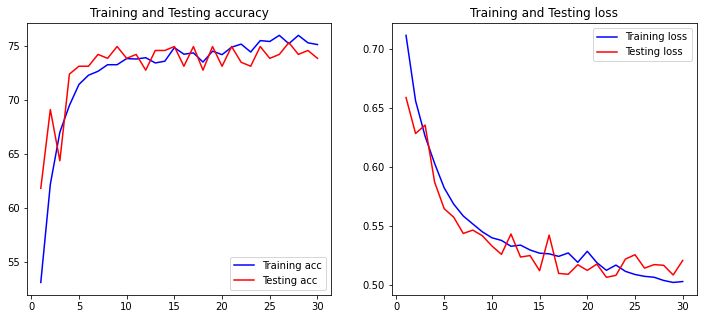

Training Accuracy: 0.7566
Testing Accuracy:  0.7382
Accuracy = 73.82%
AUC      = 0.74478
F1       = 0.73134
[[105  48]
 [ 24  98]]




In [13]:
# Print statistics
plot_history(score)


loss, accuracy = model.evaluate(trainX, trainY, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(testX, testY, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


# Predictions of the classification model
pred = model.predict(testX)

# Evaluation of the classification model
evaluate_model(testY, pred)

# Case study II: Sentinel model (**with** data preprocessing)

## Preprocess data
1. Lower case
2. Remove punctuation
2. Remove stopping words
3. Lemmatization (or Stemming)

In [ ]:
Sentences_train = preprocess(Series=Sentences_train, verbose=False)
Sentences_test = preprocess(Series=Sentences_test, verbose=False)

In [ ]:
# Use keras Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(Sentences_train)

trainX = tokenizer.texts_to_sequences(Sentences_train)
testX  = tokenizer.texts_to_sequences(Sentences_test)

# Vocabulary size
vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index
print('Vocabulary size: ', vocab_size)

# Pad sequence
maxlen = 100
trainX = pad_sequences(trainX, padding='post', maxlen=maxlen)
testX = pad_sequences(testX, padding='post', maxlen=maxlen)

## Setup model & train

In [ ]:
# Retrieve the embedding matrix
embedding_dim = 50
embedding_matrix = create_embedding_matrix('Data/embedding_matrix/glove.6B.50d.txt', tokenizer.word_index, embedding_dim)


nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print('Coverage: %.2f%%' % (100 * nonzero_elements/len(tokenizer.word_index)))

In [ ]:
# Setup model
model = Sequential()
model.add(Embedding(input_dim    = vocab_size, 
                    output_dim   = embedding_dim, 
                     weights = [embedding_matrix],
                     input_length = maxlen,
                     trainable=False))
#model.add(Flatten())
model.add(GlobalMaxPool1D())
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.summary()


# Train model
score = model.fit(trainX, trainY,
                  epochs          = 30, 
                  batch_size      = 64, 
                  verbose         = 1, 
                  validation_data = (testX, testY))

## Model evaluation

In [ ]:
# Print statistics
plot_history(score)


loss, accuracy = model.evaluate(trainX, trainY, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(testX, testY, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))


# Predictions of the classification model
pred = model.predict(testX)

# Evaluation of the classification model
evaluate_model(testY, pred)